In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms

import os
import glob
import zipfile
from time import time
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [43]:
import os, zipfile, glob

zip_path = "/content/10min_HT.zip"
extract_root = "/content"
extract_dir = os.path.join(extract_root, "10min_HT")  # expected folder name

# 1) Extract only if not already extracted
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, "r") as z:
        print(f"Extracting {zip_path} to {extract_root} ...")
        z.extractall(extract_root)
    print("Extraction done.")
else:
    print(f"{extract_dir} already exists, skipping extraction.")


/content/10min_HT already exists, skipping extraction.


In [44]:
for root, dirs, files in os.walk(extract_dir):
    print(root, "->", len(files), "files")


/content/10min_HT -> 30 files


In [45]:
# If images are directly in 10min_HT
images_path = extract_dir

# If they are inside a subfolder, e.g. 10min_HT/Images, then:
# images_path = os.path.join(extract_dir, "Images")

image_files = sorted(
    glob.glob(os.path.join(images_path, "*.tif"))
    + glob.glob(os.path.join(images_path, "*.tiff"))
    + glob.glob(os.path.join(images_path, "*.png"))
)

print("Found", len(image_files), "images")

Found 30 images


In [46]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import torch

# same normalization you used before
def normalize_image_transform(img):
    np_img = np.array(img, dtype=np.float32)
    min_val = np.min(np_img)
    max_val = np.max(np_img)

    if max_val - min_val > 1e-6:
        np_img = (np_img - min_val) / (max_val - min_val)
    else:
        np_img = np.zeros_like(np_img, dtype=np.float32)

    return torch.from_numpy(np_img).unsqueeze(0)

image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Lambda(normalize_image_transform),
])

class ImageOnlyDataset(Dataset):
    def __init__(self, image_files, transform=None):
        self.image_files = image_files
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        return img   # << no mask


In [47]:
from torch.utils.data import random_split

full_dataset = ImageOnlyDataset(image_files, transform=image_transform)

torch.manual_seed(42)
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size   = int(0.1 * total_size)
test_size  = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

print("Train:", len(train_dataset), "Val:", len(val_dataset), "Test:", len(test_dataset))


Train: 24 Val: 3 Test: 3


# **VARIATIONAL AUTOENCODER**

In [48]:
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class DeconvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2)
        self.conv = ConvBlock(out_c, out_c)

    def forward(self, x):
        x = self.up(x)
        x = self.conv(x)
        return x

class ImprovedVAE(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.latent_dim = latent_dim

        # ---- Encoder: 3 downsamplings -> 32x32 ----
        self.enc1 = ConvBlock(1, 32)          # 256x256
        self.pool1 = nn.MaxPool2d(2)          # 128x128

        self.enc2 = ConvBlock(32, 64)
        self.pool2 = nn.MaxPool2d(2)          # 64x64

        self.enc3 = ConvBlock(64, 128)
        self.pool3 = nn.MaxPool2d(2)          # 32x32

        # bottleneck feature map: 128 x 32 x 32
        self.flatten = nn.Flatten()
        flat_dim = 128 * 32 * 32

        self.fc_mu     = nn.Linear(flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(flat_dim, latent_dim)

        # ---- Decoder ----
        self.fc_dec = nn.Linear(latent_dim, flat_dim)

        self.dec3 = ConvBlock(128, 128)   # keep 32x32
        self.up2  = DeconvBlock(128, 64)  # 32 -> 64
        self.up1  = DeconvBlock(64, 32)   # 64 -> 128
        self.up0  = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)  # 128 -> 256
        self.out_conv = nn.Conv2d(16, 1, kernel_size=3, padding=1)

        # final activation for [0,1] images
        self.out_act = nn.Sigmoid()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x = self.enc1(x)
        x = self.pool1(x)
        x = self.enc2(x)
        x = self.pool2(x)
        x = self.enc3(x)
        x = self.pool3(x)

        h = self.flatten(x)
        mu     = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def decode(self, z):
        h = self.fc_dec(z)
        x = h.view(-1, 128, 32, 32)

        x = self.dec3(x)
        x = self.up2(x)
        x = self.up1(x)
        x = self.up0(x)
        x = self.out_conv(x)
        x = self.out_act(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z)
        return x_hat, mu, logvar



In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --------- VAE LOSS FUNCTION ---------
def vae_loss(x, x_hat, mu, logvar, beta=0.01):
  #beta = 0.01 This reduces regularisation even more → closer to AE behaviour,
  #slightly sharper reconstructions, but the latent space becomes less nicely Gaussian.
  #also tried w/ 1.0, 0.1
    """
    VAE loss:
      - recon_loss: per-pixel MSE (like your AE)
      - kl_loss: KL divergence, normalized per pixel
      - beta: weight of the KL term
    Returns: total_loss, recon_loss, kl_loss
    """
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(x_hat, x, reduction='mean')

    # KL divergence (sum over batch & latent dim)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Normalize KL to per-pixel scale (B * H * W, assuming 1 channel)
    n_pixels = x.size(0) * x.size(2) * x.size(3)
    kl = kl / n_pixels

    # Total loss
    loss = recon_loss + beta * kl

    return loss, recon_loss, kl

#MODEL + OPTIMIZER
latent_dim = 512 ## get some extra detail, but it’s diminishing returns
model = ImprovedVAE(latent_dim).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 80
train_loss_history = []
val_loss_history = []

print("Starting VAE Training...")

for epoch in range(num_epochs):
    model.train()
    batch_losses = []

    #TRAINING
    for images in train_loader:
        images = images.to(device).float()

        optimizer.zero_grad()
        x_hat, mu, logvar = model(images)

        loss, recon_loss, kl_loss = vae_loss(images, x_hat, mu, logvar, beta=0.01)
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

    avg_train_loss = np.mean(batch_losses)
    train_loss_history.append(avg_train_loss)

    #VALIDATION
    model.eval()
    val_batch_losses = []
    with torch.no_grad():
        for images in val_loader:
            images = images.to(device).float()
            x_hat, mu, logvar = model(images)
            val_loss, _, _ = vae_loss(images, x_hat, mu, logvar, beta=0.01)
            val_batch_losses.append(val_loss.item())

    avg_val_loss = np.mean(val_batch_losses)
    val_loss_history.append(avg_val_loss)

    if (epoch + 1) % 5 == 0:
        print(
            f"Epoch [{epoch+1}/{num_epochs}] | "
            f"Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f}"
        )

print("VAE Training Complete.")




Starting VAE Training...
Epoch [5/80] | Train Loss: 0.01590 | Val Loss: 0.01518
Epoch [10/80] | Train Loss: 0.01474 | Val Loss: 0.01394
Epoch [15/80] | Train Loss: 0.00642 | Val Loss: 0.00476
Epoch [20/80] | Train Loss: 0.00255 | Val Loss: 0.00258
Epoch [25/80] | Train Loss: 0.00241 | Val Loss: 0.00233
Epoch [30/80] | Train Loss: 0.00235 | Val Loss: 0.00218
Epoch [35/80] | Train Loss: 0.00224 | Val Loss: 0.00224
Epoch [40/80] | Train Loss: 0.00217 | Val Loss: 0.00219
Epoch [45/80] | Train Loss: 0.00219 | Val Loss: 0.00218
Epoch [50/80] | Train Loss: 0.00218 | Val Loss: 0.00218
Epoch [55/80] | Train Loss: 0.00213 | Val Loss: 0.00209
Epoch [60/80] | Train Loss: 0.00210 | Val Loss: 0.00199
Epoch [65/80] | Train Loss: 0.00193 | Val Loss: 0.00207
Epoch [70/80] | Train Loss: 0.00171 | Val Loss: 0.00182
Epoch [75/80] | Train Loss: 0.00161 | Val Loss: 0.00150
Epoch [80/80] | Train Loss: 0.00162 | Val Loss: 0.00159
VAE Training Complete.


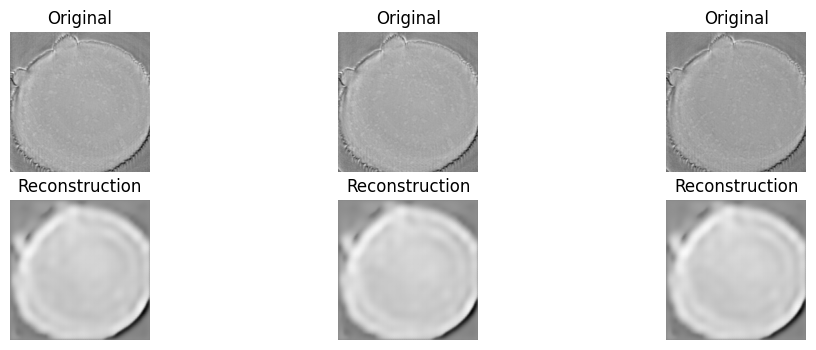

In [51]:
model.eval()

with torch.no_grad():
    images = next(iter(val_loader))
    images = images.to(device)
    x_hat, _, _ = model(images)

# Convert to numpy
images = images.cpu().numpy()
x_hat = x_hat.cpu().numpy()

batch_size = images.shape[0]
n_show = min(batch_size, 4)   # show max 4 samples

plt.figure(figsize=(12, 4))

for i in range(n_show):
    # Original
    plt.subplot(2, n_show, i + 1)
    plt.imshow(images[i, 0], cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstruction
    plt.subplot(2, n_show, i + 1 + n_show)
    plt.imshow(x_hat[i, 0], cmap='gray')
    plt.title("Reconstruction")
    plt.axis('off')

plt.show()



In [53]:
images = next(iter(val_loader))
images = images.to(device).float()
x_hat, mu, logvar = model(images)

print("INPUT  stats  -> min:", images.min().item(),
      "max:", images.max().item(),
      "mean:", images.mean().item(),
      "std:", images.std().item())

print("X_HAT stats  -> min:", x_hat.min().item(),
      "max:", x_hat.max().item(),
      "mean:", x_hat.mean().item(),
      "std:", x_hat.std().item())


INPUT  stats  -> min: 0.0 max: 1.0 mean: 0.6248008012771606 std: 0.07120327651500702
X_HAT stats  -> min: 0.2836693823337555 max: 0.7352215051651001 mean: 0.6217285990715027 std: 0.057249680161476135


VAE W/ SKIPPED CONNECTION - VAE + UNET -- We still have the probabilistic bottleneck, but the decoder also receives encoder feature maps via skip connections to better preserve local details (like the pores).

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

class SkipVAE(nn.Module):
    def __init__(self, latent_dim=256):
        super().__init__()
        self.latent_dim = latent_dim

        # ------------ Encoder ------------
        self.enc1 = ConvBlock(1, 32)           # 256x256
        self.pool1 = nn.MaxPool2d(2)           # 128x128

        self.enc2 = ConvBlock(32, 64)          # 128x128
        self.pool2 = nn.MaxPool2d(2)           # 64x64

        self.enc3 = ConvBlock(64, 128)         # 64x64
        self.pool3 = nn.MaxPool2d(2)           # 32x32

        # bottleneck: 128 x 32 x 32
        self.flatten = nn.Flatten()
        flat_dim = 128 * 32 * 32

        self.fc_mu     = nn.Linear(flat_dim, latent_dim)
        self.fc_logvar = nn.Linear(flat_dim, latent_dim)

        # ------------ Decoder ------------
        self.fc_dec = nn.Linear(latent_dim, flat_dim)

        # bottom (32x32)
        self.dec3 = ConvBlock(128, 128)

        # up to 64x64, concat skip3 (128 + 128 -> 256 -> 64)
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)    # 32 -> 64
        self.dec2 = ConvBlock(64 + 128, 64)

        # up to 128x128, concat skip2 (64 + 64 -> 128 -> 32)
        self.up1 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)     # 64 -> 128
        self.dec1 = ConvBlock(32 + 64, 32)

        # up to 256x256, concat skip1 (32 + 32 -> 64 -> 16)
        self.up0 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)     # 128 -> 256
        self.dec0 = ConvBlock(16 + 32, 16)

        self.out_conv = nn.Conv2d(16, 1, kernel_size=3, padding=1)
        self.out_act = nn.Sigmoid()  # images in [0, 1]

    # reparameterization trick
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        # encoder with skips
        x1 = self.enc1(x)           # 32 x 256 x 256
        p1 = self.pool1(x1)         # 32 x 128 x 128

        x2 = self.enc2(p1)          # 64 x 128 x 128
        p2 = self.pool2(x2)         # 64 x 64 x 64

        x3 = self.enc3(p2)          # 128 x 64 x 64
        p3 = self.pool3(x3)         # 128 x 32 x 32

        h = self.flatten(p3)
        mu     = self.fc_mu(h)
        logvar = self.fc_logvar(h)

        skips = (x1, x2, x3)
        return mu, logvar, skips

    def decode(self, z, skips):
        x1, x2, x3 = skips

        h = self.fc_dec(z)
        x = h.view(-1, 128, 32, 32)

        # bottom
        x = self.dec3(x)  # 128 x 32 x 32

        # up to 64x64 + skip3
        x = self.up2(x)              # 64 x 64 x 64
        x = torch.cat([x, x3], dim=1)  # (64+128)=192 x 64 x 64
        x = self.dec2(x)             # 64 x 64 x 64

        # up to 128x128 + skip2
        x = self.up1(x)              # 32 x 128 x 128
        x = torch.cat([x, x2], dim=1)  # (32+64)=96 x 128 x 128
        x = self.dec1(x)             # 32 x 128 x 128

        # up to 256x256 + skip1
        x = self.up0(x)              # 16 x 256 x 256
        x = torch.cat([x, x1], dim=1)  # (16+32)=48 x 256 x 256
        x = self.dec0(x)             # 16 x 256 x 256

        x = self.out_conv(x)
        x = self.out_act(x)
        return x

    def forward(self, x):
        mu, logvar, skips = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decode(z, skips)
        return x_hat, mu, logvar


In [55]:
# --------- VAE LOSS FUNCTION ---------
def vae_loss(x, x_hat, mu, logvar, beta=0.01):
  #beta = 0.01 This reduces regularisation even more → closer to AE behaviour,
  #slightly sharper reconstructions, but the latent space becomes less nicely Gaussian.
  #also tried w/ 1.0, 0.1
    """
    VAE loss:
      - recon_loss: per-pixel MSE
      - kl_loss: KL divergence, normalized per pixel
      - beta: weight of the KL term
    Returns: total_loss, recon_loss, kl_loss
    """
    # Reconstruction loss (MSE)
    recon_loss = F.mse_loss(x_hat, x, reduction='mean')

    # KL divergence (sum over batch & latent dim)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Normalize KL to per-pixel scale (B * H * W, assuming 1 channel)
    n_pixels = x.size(0) * x.size(2) * x.size(3)
    kl = kl / n_pixels

    # Total loss
    loss = recon_loss + beta * kl

    return loss, recon_loss, kl

#MODEL + OPTIMIZER
latent_dim = 512 ## get some extra detail, but it’s diminishing returns
model = SkipVAE(latent_dim).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 80
train_loss_history = []
val_loss_history = []

print("Starting VAE + UNET Training...")

for epoch in range(num_epochs):
    model.train()
    batch_losses = []

    #TRAINING
    for images in train_loader:
        images = images.to(device).float()

        optimizer.zero_grad()
        x_hat, mu, logvar = model(images)

        loss, recon_loss, kl_loss = vae_loss(images, x_hat, mu, logvar, beta=0.01)
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

    avg_train_loss = np.mean(batch_losses)
    train_loss_history.append(avg_train_loss)

    #VALIDATION
    model.eval()
    val_batch_losses = []
    with torch.no_grad():
        for images in val_loader:
            images = images.to(device).float()
            x_hat, mu, logvar = model(images)
            val_loss, _, _ = vae_loss(images, x_hat, mu, logvar, beta=0.01)
            val_batch_losses.append(val_loss.item())

    avg_val_loss = np.mean(val_batch_losses)
    val_loss_history.append(avg_val_loss)

    if (epoch + 1) % 5 == 0:
        print(
            f"Epoch [{epoch+1}/{num_epochs}] | "
            f"Train Loss: {avg_train_loss:.5f} | Val Loss: {avg_val_loss:.5f}"
        )

print("VAE + UNET Training Complete.")


Starting VAE + UNET Training...
Epoch [5/80] | Train Loss: 0.02582 | Val Loss: 0.02486
Epoch [10/80] | Train Loss: 0.02471 | Val Loss: 0.02371
Epoch [15/80] | Train Loss: 0.02208 | Val Loss: 0.02058
Epoch [20/80] | Train Loss: 0.00677 | Val Loss: 0.00426
Epoch [25/80] | Train Loss: 0.00292 | Val Loss: 0.00233
Epoch [30/80] | Train Loss: 0.00225 | Val Loss: 0.00221
Epoch [35/80] | Train Loss: 0.00206 | Val Loss: 0.00202
Epoch [40/80] | Train Loss: 0.00200 | Val Loss: 0.00194
Epoch [45/80] | Train Loss: 0.00188 | Val Loss: 0.00178
Epoch [50/80] | Train Loss: 0.00176 | Val Loss: 0.00176
Epoch [55/80] | Train Loss: 0.00170 | Val Loss: 0.00164
Epoch [60/80] | Train Loss: 0.00163 | Val Loss: 0.00158
Epoch [65/80] | Train Loss: 0.00154 | Val Loss: 0.00153
Epoch [70/80] | Train Loss: 0.00148 | Val Loss: 0.00145
Epoch [75/80] | Train Loss: 0.00138 | Val Loss: 0.00135
Epoch [80/80] | Train Loss: 0.00126 | Val Loss: 0.00122
VAE + UNET Training Complete.


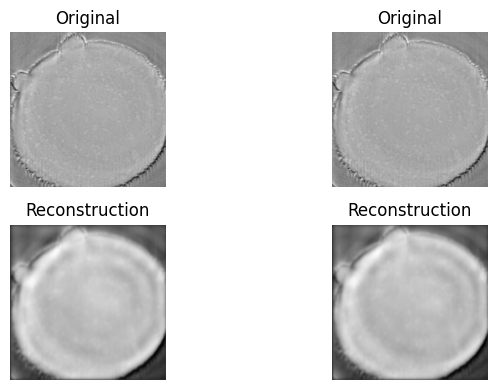

In [56]:
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    images = next(iter(val_loader))
    images = images.to(device).float()
    x_hat, _, _ = model(images)

images = images.cpu().numpy()
x_hat  = x_hat.cpu().numpy()

n = 2  # show first 2
plt.figure(figsize=(8, 4))
for i in range(n):
    # original
    plt.subplot(2, n, i+1)
    plt.imshow(images[i, 0], cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # reconstruction
    plt.subplot(2, n, n + i + 1)
    plt.imshow(x_hat[i, 0], cmap='gray')
    plt.title("Reconstruction")
    plt.axis('off')

plt.tight_layout()
plt.show()
